In [1]:
import os
import time
import numpy as np

from PIL import Image
from IPython import display
from IPython.display import Video
import matplotlib.pyplot as plt
import seaborn as sns
import moviepy.editor as mpy
from base64 import b64encode

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import resize

import wandb

In [2]:
wandb.login()

wandb: Currently logged in as: parameterized. Use `wandb login --relogin` to force relogin


True

In [3]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['image.cmap'] = 'binary'
sns.set_theme(style='darkgrid')

def display_video(path, loop=True):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display.display(display.HTML(f'''<video src="{
        data_url}" controls=true autoplay=true {
        "loop=true " if loop else ""}/>'''))

eps = 1e-5
device = 'cuda'

In [4]:
# todo: compute actual mean/std
data_mean = np.full(3, .5)
data_std = np.full(3, .25)
print(data_mean, data_std)

# norm and inverse norm transformations
norm_t = transforms.Normalize(data_mean, data_std)
invnorm_t = transforms.Normalize(-data_mean / data_std, 1 / data_std)

tensor_to_img = lambda x: invnorm_t(x).clip(0, 1).movedim(-3, -1).detach().cpu()

[0.5 0.5 0.5] [0.25 0.25 0.25]


In [5]:
frames_path = 'datasets/jams-germs/frames/Earthworm Under Microscope'
frame_count = len(os.listdir(frames_path))
frame_area = 910 * 512

n_frames = 4
n_levels = 4
patch_size = 32
hidden_channels = 64
hidden_feats = 128

In [6]:
def sample_video_patches(batch_size=32, patch_size=32, scale=(1, 1),
                         n_frames=n_frames, start_frames=None):
    if start_frames is None:
        start_frames = np.random.randint(frame_count - n_frames + 1, size=(batch_size,))
        
    ps = patch_size
    area = ps**2 / frame_area
    rrc = transforms.RandomResizedCrop((ps, ps),
        scale=(area * scale[0], area * scale[1]), ratio=(1, 1))
    rrc = transforms.Compose([transforms.ToTensor(), rrc])
    
    batch = torch.empty(batch_size, n_frames, 3, ps, ps)
    for i in range(batch_size):
        for j in range(n_frames):
            img = Image.open(f'{frames_path}/{start_frames[i] + j}.jpg')
            batch[i, j] = rrc(img)
    
    return batch

In [7]:
def get_batch(batch_size=32, patch_size=32, scale=(1, 1),
              n_levels=n_levels, n_frames=n_frames, start_frames=None):
    if start_frames is None:
        start_frames = np.random.randint(frame_count - n_frames + 1, size=(batch_size,))
    
    x0s = []
    ps = patch_size
    for i in range(n_levels):
        x0s.append(torch.empty(batch_size, n_frames, 3, ps, ps, device=device))
        ps //= 2
    
    x0s[0] = norm_t(sample_video_patches(batch_size=batch_size, patch_size=patch_size,
        scale=scale, n_frames=n_frames, start_frames=start_frames)).to(device)
    for i in range(1, n_levels):
        # resize all frames by flattening onto batch dim
        x0_prev_timeflat = x0s[i - 1].view(-1, *x0s[i - 1].shape[-3:])
        x0s[i] = resize(x0_prev_timeflat, x0s[i].shape[-1]).view(x0s[i].shape)
    
    return x0s

embed_channels = 16 # divisible by 2

def embed_ts(t, n_freqs=embed_channels // 2):
    emb = t[..., None] * 2**torch.arange(n_freqs, device=device) * torch.pi / 2
    return torch.cat([emb.sin(), emb.cos()], dim=-1)

In [8]:
class Pool():
    def __init__(self, pool_size):
        self.size = pool_size

In [9]:
# (910*512)/(32*32) = 455 (full size patches)
def gen_trainset_video(path, fps=12):
    bx = get_batch(patch_size=32, scale=(455, 455))
    def make_frame(i_list):
        frame = torchvision.utils.make_grid(invnorm_t(bx[0][:16, i_list[0]]), nrow=4)
        i_list[0] = min(i_list[0] + 1, bx[0].shape[1] - 1)
        frame = resize(frame, 512).permute(1, 2, 0)
        return frame.clip(0, 1).multiply(255).int().cpu().numpy()
    
    os.makedirs(os.path.dirname(path), exist_ok=True)
    i_list = [0]
    clip = mpy.VideoClip(lambda t: make_frame(i_list), duration=n_frames/fps)
    clip.write_videofile(path, fps=fps)
    return clip

clip = gen_trainset_video('output/trainset_video.mp4')
display_video('output/trainset_video.mp4', loop=True)

Moviepy - Building video output/trainset_video.mp4.
Moviepy - Writing video output/trainset_video.mp4



Moviepy - Done !
Moviepy - video ready output/trainset_video.mp4


In [10]:
class LayerNorm(nn.Module):
    def forward(self, x):
        var, mean = torch.var_mean(x, dim=1,
            unbiased=False, keepdim=True)
        return (x - mean) * (var + eps).rsqrt()

class FractalDN(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Conv2d((3 + hidden_channels * 2) * 3, hidden_feats, 3,
                            padding=1, padding_mode='replicate')
        self.l2 = nn.Conv2d(hidden_feats, 3 + hidden_channels, 1)
        
        self.scale_shift_l1 = nn.Sequential(
            nn.SiLU(),
            nn.Linear(embed_channels, hidden_feats * 2))
        self.scale_shift_l2 = nn.Sequential(
            nn.SiLU(),
            nn.Linear(embed_channels, (3 + hidden_channels) * 2))
        
        self.layer_norm = LayerNorm()
        
        nn.init.zeros_(self.l2.weight)
        nn.init.zeros_(self.l2.bias)
    
    def forward(self, bts, btes, bxts):
        """
        Evaluate the model
        
        Args:
            bts, btes, bxts: Lists of tensors
                with resolution decreasing by half (e.g. 32, 16, 8).
                bts - batch t tensors
                btes - batch t embedding tensors
                bxts - batch x_t tensors in the concatenated form
                [x_0, hidden channels (this frame), hidden channels (last frame)]
        
        Returns:
            A list of concatenated predictions for
            [x_0, hidden channels (this frame)]
        """
        preds = []
        ss_l1 = self.scale_shift_l1(btes)
        ss_l2 = self.scale_shift_l2(btes)
        for i, bxt in enumerate(bxts):
            # higher res, lower res
            hr = bxt if i == 0 else resize(bxts[i - 1], bxt.shape[-1])
            lr = bxt if i == len(bxts) - 1 else resize(
                bxts[i + 1], bxt.shape[-1])
            xin = torch.cat([hr, bxt, lr], dim=1)
            
            h = self.l1(xin).relu()
            h = self.layer_norm(h) * ss_l1[:, :hidden_feats, None, None]
            h = h + ss_l1[:, hidden_feats:, None, None]
            
            h = self.l2(h)
            h = self.layer_norm(h) * ss_l2[:, :3 + hidden_channels, None, None]
            py = h + ss_l2[:, 3 + hidden_channels:, None, None]
            
            preds.append(bxt[:, :3 + hidden_channels] + py)
        
        return preds

model = FractalDN().cuda()

opt = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt,
    lambda epoch: max(0.95**epoch, 0.1))
loss_fn = nn.MSELoss()
losses = []

2,000 / 2,000
52m - eta 1s
lr: 0.00042869
loss: 0.06790024


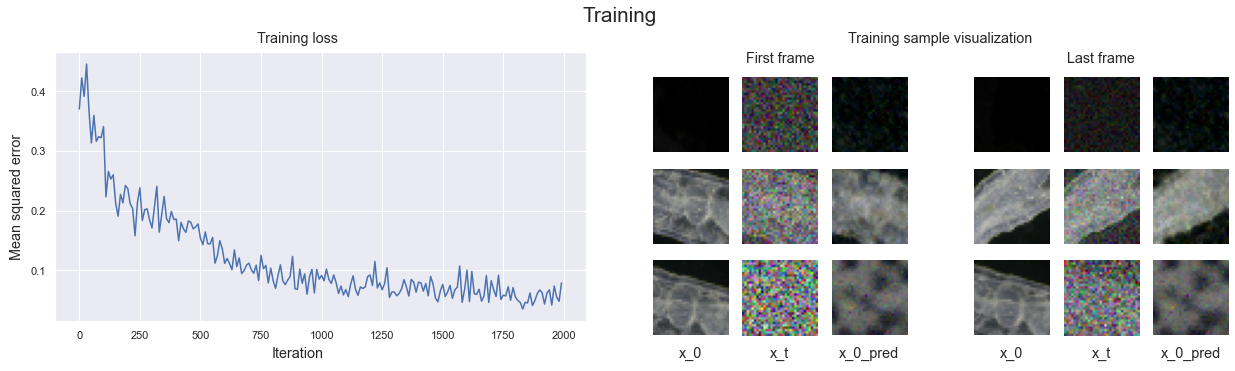

Saved to models/FractalDN_video_836985308.pt


train/loss,█▆▄▄▄▅▄▄▃▄▃▃▃▂▂▂▂▂▂▁▂▁▁▂▂▂▂▂▂▁▂▂▁▁▂▂▁▁▁▂
train/step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/loss,0.07867
train/step,2000


In [11]:
model_id = f'{np.random.randint(1e9):09d}'

run = wandb.init(
    #mode='disabled',
    project='FractalDN',
    config={
        'model_id': model_id,
        'hidden_channels': hidden_channels,
        'hidden_feats': hidden_feats,
        'n_frames': n_frames,
        'n_levels': n_levels,
        'patch_size': patch_size,
        'video': True
    },
    save_code=True)
wandb.define_metric('train/step')
wandb.define_metric('train/*', step_metric='train/step')

with run:
    print('Training...')
    train_st = time.time()
    time_to_s = lambda t: f'{int(t)}s' if t < 60 else f'{int(t / 60)}m'
    
    train_iters = int(2e3)
    batch_size = 16
    model_steps_per_frame = (4, 8) # min, max inclusive
    
    loss_every_n = 10
    display_every_n = 20
    scheduler_every_n = 500
    
    for i in range(train_iters):        
        bx0s = get_batch(batch_size=batch_size, n_frames=n_frames, scale=(455, 455))
        bts = torch.rand(batch_size, n_frames, device=device)
        btes = embed_ts(bts)
        bt0 = torch.zeros(batch_size, device=device)
        bte0 = embed_ts(bt0)
        bns = [torch.randn_like(bx0s[0])]
        ps = patch_size
        for j in range(1, n_levels):
            ps //= 2
            # resize all frames by flattening onto batch dim
            bn_prev_timeflat = bns[j - 1].view(-1, *bns[-1].shape[-3:])
            bns.append(resize(bn_prev_timeflat, ps).view(bx0s[j].shape))
        
        bxt_rgbs = [torch.lerp(bx0, bn, bts[..., None, None, None])
                   for bx0, bn in zip(bx0s, bns)]
        
        last_bxt_hiddens = [torch.randn(batch_size, hidden_channels, *x0.shape[-2:],
            device=device) for x0 in bx0s]
        
        # predict x_0
        loss = 0
        for frame_id in range(n_frames):
            # randomize hiddens every frame
            bxt_hiddens = [torch.randn(batch_size, hidden_channels, *x0.shape[-2:],
                device=device) for x0 in bx0s]
            # test also randomizing last, should be frame-independent now
            # last_bxt_hiddens = [torch.randn(batch_size, hidden_channels, *x0.shape[-2:],
            #     device=device) for x0 in bx0s]
            
            spf = np.random.randint(model_steps_per_frame[0], model_steps_per_frame[1] + 1)
            for _ in range(spf):
                bxts = [torch.cat([bxt_rgb[:, frame_id], bxt_hidden, last_bxt_hidden], dim=1)
                        for bxt_rgb, bxt_hidden, last_bxt_hidden in zip(bxt_rgbs, bxt_hiddens, last_bxt_hiddens)]
                x0_preds = model(bts[:, frame_id], btes[:, frame_id], bxts)
                # only update hidden channels
                bxt_hiddens = [x0p[:, 3:3 + hidden_channels] for x0p in x0_preds]
            
            if frame_id == 0:
                first_x0_preds = x0_preds
            
            target_rgbs = [bx0[:, frame_id] for bx0 in bx0s]
            loss = loss + torch.cat([loss_fn(x0p[:, :3], target_rgb)[None]
                for x0p, target_rgb in zip(x0_preds, target_rgbs)], dim=0).mean()
            
            # compute frame-persistent hiddens using x0
            fp_bxt_hiddens = [torch.randn(batch_size, hidden_channels, *x0.shape[-2:],
                device=device) for x0 in bx0s]
            for _ in range(spf):
                fp_bxts = [torch.cat([bx0[:, frame_id], fp_bxt_hidden, last_bxt_hidden], dim=1)
                           for bx0, fp_bxt_hidden, last_bxt_hidden in zip(bx0s, fp_bxt_hiddens, last_bxt_hiddens)]
                fp_x0_preds = model(bt0, bte0, fp_bxts)
                fp_bxt_hiddens = [x0p[:, 3:3 + hidden_channels] for x0p in x0_preds]
            
            last_bxt_hiddens = fp_bxt_hiddens
        
        loss = loss / n_frames
        
        # opt step
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # plot
        if (i + 1) % loss_every_n == 0:
            losses.append(loss.item())
            wandb.log({
                'train/step': i + 1,
                'train/loss': loss.item()
            })
        if (i + 1) % display_every_n == 0:
            display.clear_output(wait=True)
            print(f'{i + 1 :,} / {train_iters:,}')
            time_passed = time.time() - train_st
            eta = time_passed * (train_iters - i) / max(i, 1)
            print(f'{time_to_s(time_passed)} - eta {time_to_s(eta)}')
            print(f'lr: {opt.state_dict()["param_groups"][0]["lr"]:.8f}')
            print(f'loss: {np.mean(losses[-100:]):.8f}')
            
            fig = plt.figure(constrained_layout=True, figsize=(5 * 3.4, 5))
            fig.suptitle('Training', fontsize='xx-large')
            loss_fig, vis_fig = fig.subfigures(1, 2, wspace=.1)
            
            loss_fig.suptitle('Training loss')
            loss_fig.supxlabel('Iteration')
            loss_fig.supylabel('Mean squared error')
            
            vis_fig.suptitle('Training sample visualization')
            
            ax = loss_fig.gca()
            sns.lineplot(np.arange(len(losses)) * loss_every_n, losses, ax=ax)
            
            vis_first, vis_last = vis_fig.subfigures(1, 2, wspace=.1)
            vis_first.suptitle('First frame')
            vis_last.suptitle('Last frame')
            
            for vis in [vis_first, vis_last]:                
                vis_col_figs = vis.subfigures(1, 3)
                x0_axes, xt_axes, x0p_axes = [
                    v.subplots(3, 1) for v in vis_col_figs]
                for f, label in zip(vis_col_figs, ['x_0', 'x_t', 'x_0_pred']):
                    f.supxlabel(label)
                
                vis_frame = -1
                if vis == vis_first:
                    vis_frame = 0
                    x0_preds = first_x0_preds

                # show random samples of low, mid, high ranges of t
                t_sort = torch.argsort(bts[:, vis_frame])
                for k in range(3):
                    row_id = t_sort[np.random.randint(
                        t_sort.shape[0] // 3 * k,
                        t_sort.shape[0] // 3 * (k + 1))]
                    x0_axes[k].imshow(tensor_to_img(bx0s[0][row_id, vis_frame]))
                    x0_axes[k].axis('off')
                    xt_axes[k].imshow(tensor_to_img(bxt_rgbs[0][row_id, vis_frame, :3]))
                    xt_axes[k].axis('off')
                    x0p_axes[k].imshow(tensor_to_img(x0_preds[0][row_id, :3]))
                    x0p_axes[k].axis('off')
            
            plt.show()
        if (i + 1) % scheduler_every_n == 0:
            scheduler.step()
    
    model_path = f'models/FractalDN_video_{model_id}.pt'
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    torch.save(model, model_path)
    print(f'Saved to {model_path}')

In [12]:
from tqdm import tqdm
tqdm._instances.clear()

diffusion_steps = 64
vid_batch_size = 4
vid_patch_size = 32

def gen_video(path, duration=2, fps=24):
    def make_frame(frame_state):        
        with torch.no_grad():
            ps = vid_patch_size
            frame_imgs = torch.empty(4, 4, 3, ps, ps)
            
            # initialize rgbs for frame
            bxt_rgbs = [torch.randn(vid_batch_size, 3, ps, ps, device=device)]
            for i in range(1, n_levels):
                ps //= 2
                bxt_rgbs.append(resize(bxt_rgbs[-1], ps))
            
            # load last hiddens if not first frame
            if frame_state.get('bxt_hiddens') is not None:
                last_bxt_hiddens = frame_state['bxt_hiddens']
            else:
                last_bxt_hiddens = [torch.randn(vid_batch_size, hidden_channels, *rgb.shape[-2:],
                    device=device) for rgb in bxt_rgbs]
            
            # reverse diffusion steps
            for i, t in enumerate(np.linspace(1, 0, diffusion_steps, endpoint=False)):
                bts = torch.full((vid_batch_size,), t, device=device)
                btes = embed_ts(bts)
                
                # randomize hiddens every diffusion step
                bxt_hiddens = [torch.randn(vid_batch_size, hidden_channels, *rgb.shape[-2:],
                    device=device) for rgb in bxt_rgbs]
                
                for _ in range(model_steps_per_frame[1]): # do max steps
                    bxts = [torch.cat([bxt_rgb, bxt_hidden, last_bxt_hidden], dim=1)
                            for bxt_rgb, bxt_hidden, last_bxt_hidden in zip(bxt_rgbs, bxt_hiddens, last_bxt_hiddens)]
                    x0_preds = model(bts, btes, bxts)
                    # only update hidden channels
                    bxt_hiddens = [x0p[:, 3:3 + hidden_channels] for x0p in x0_preds]
                
                # reverse diffusion step
                lerp_t = (1 / diffusion_steps / (t + eps)).clip(0, 1)
                bxt_rgbs = [torch.lerp(bxt_rgb, x0p[:, :3], lerp_t)
                            for bxt_rgb, x0p in zip(bxt_rgbs, x0_preds)]
                
                # show 4 of the 64 diffusion steps
                if i % 16 == 15:
                    frame_imgs[:, i // 16] = invnorm_t(bxt_rgbs[0])
            
            # use frame-persistent hiddens from final predicted x0
            frame_state['bxt_hiddens'] = bxt_hiddens
            
            #frame = torchvision.utils.make_grid(invnorm_t(bxt_rgbs[0][:, 3:]), nrow=round(vid_batch_size**.5))
            frame = torchvision.utils.make_grid(frame_imgs.view(-1, *frame_imgs.shape[2:]), nrow=4)
            frame = resize(frame, 512).permute(1, 2, 0)
            return frame.clip(0, 1).multiply(255).int().cpu().numpy()
    
    os.makedirs(os.path.dirname(path), exist_ok=True)
    frame_state = {}
    clip = mpy.VideoClip(lambda t: make_frame(frame_state), duration=duration)
    clip.write_videofile(path, fps=fps)
    return clip

clip = gen_video('output/fractal_dn_video.mp4')
display_video('output/fractal_dn_video.mp4', loop=False)

Moviepy - Building video output/fractal_dn_video.mp4.
Moviepy - Writing video output/fractal_dn_video.mp4



Moviepy - Done !
Moviepy - video ready output/fractal_dn_video.mp4


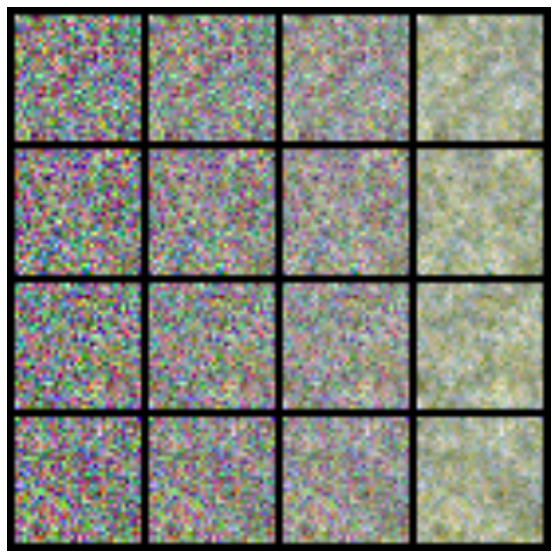

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(clip.get_frame(2) / 255)
plt.axis('off')
plt.show()